In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.copy2("/content/drive/MyDrive/utilities.py", "/content/utilities.py")
shutil.copy2("/content/drive/MyDrive/ConvNet.py", "/content/ConvNet.py")
shutil.copy2("/content/drive/MyDrive/config.py", "/content/config.py")

'/content/config.py'

In [3]:
import ConvNet
import config
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.utils import to_categorical
from tensorflow.data import AUTOTUNE
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import argparse
import os
import numpy as np
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MultiLabelBinarizer
from IPython.display import Audio, clear_output, display
from glob import glob
import random
from utilities import acuracia0, acuracia1, acuracia2
import utilities

In [4]:
model = ConvNet.ConvNet

In [ ]:
model.summary()

# DA=0.0

In [ ]:
DA = 0

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/aval_morl_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/training_morl_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [ ]:
TRAIN_DATASET = os.path.join("/content", "training_morl_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        if np.random.rand()<=DA:            
            fator = np.random.choice([0.8, 0.85, 0.9, 0.95, 1, 1.05, 1.1, 1.15, 1.2])            
            fator = fator.astype(np.float32)
            rand_value = tf.constant(fator, dtype=tf.float32)
                        
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)
            
            def f1(): return 1.0
            def f2(): return fator
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator
            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)
            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)
                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
        else:
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
        return (image_aug, label_aug)
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [ ]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [ ]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [ ]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [ ]:
list_images_train = list(images_train.as_numpy_iterator())

In [ ]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [ ]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [ ]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8827, 40, 256, 1)
(4670, 40, 256, 1)
(8827,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [ ]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [ ]:
%%time
history = model.fit(trainDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
  6/138 [>.............................] - ETA: 52s - loss: 5.1054 - accuracy: 0.0130

138/138 [==============================] - 11s 76ms/step
Train - Acurácia 0:  0.23654695819644272
Train - Acurácia 2:  0.5107057890563045
73/73 [==============================] - 7s 101ms/step
Validation - Acurácia 0:  0.07130620985010706
validation - Acurácia 2:  0.3141327623126338
138/138 [==============================] - 98s 592ms/step - loss: 3.6454 - accuracy: 0.2283
Epoch 2/50
138/138 [==============================] - 11s 77ms/step
Train - Acurácia 0:  0.374079528718704
Train - Acurácia 2:  0.742381330010196
73/73 [==============================] - 6s 77ms/step
Validation - Acurácia 0:  0.14603854389721627
validation - Acurácia 2:  0.5638115631691649
138/138 [==============================] - 78s 567ms/step - loss: 2.6039 - accuracy: 0.3684
Epoch 3/50
138/138 [==============================] - 11s 78ms/step
Train - Acurácia 0:  0.43004418262150224
Train - Acurácia 2:  0.8342585249801745
73/73 [==============================] - 6s 77ms/step
Validation - Acurácia 0:  0.1670235546

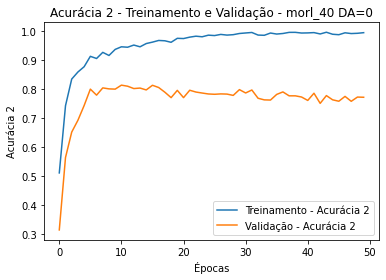

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - morl_40 DA=0')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da0'+'.pdf', format='pdf')
plt.show()

In [ ]:
np.save('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da0',acc)
np.save('/content/drive/MyDrive/Resultados/morl_40_da/val_acc2_'+'da0',val_acc)

In [ ]:
model.save('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da0')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da0')

### Training Results

In [ ]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

138/138 [==============================] - 11s 78ms/step
(8827, 140)
(8827,)
(8827,)


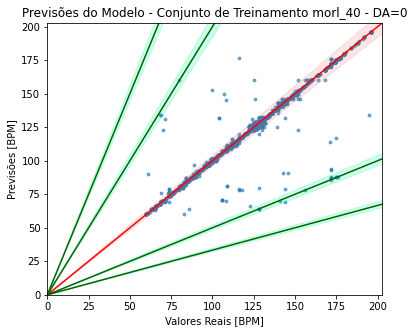

In [ ]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento morl_40 - DA=0', '/content/drive/MyDrive/Resultados/morl_40_da/prev_train_'+'da0'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_morl_40_da0'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

         Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_morl_40_da0    0.922624    0.992183     0.994222


### Validation Results

In [ ]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 6s 78ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


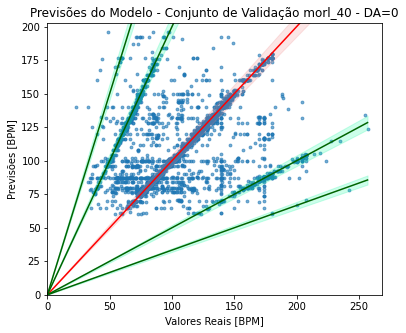

In [ ]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação morl_40 - DA=0', '/content/drive/MyDrive/Resultados/morl_40_da/prev_validation_'+'da0'+'.pdf')

In [ ]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_morl_40_da0'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

              Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_morl_40_da0    0.922624    0.992183     0.994222
1  validation_morl_40_da0    0.243683    0.576231     0.771520


In [ ]:
resultados.to_excel("/content/drive/MyDrive/Resultados/morl_40_da/Resultados_morl_40_da0.xlsx", index=False)  

# DA=0.25

In [5]:
#DA1 = 0.25

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/aval_morl_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/training_morl_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_morl_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(0.25, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [13]:
#list_images_test = list(images_test.as_numpy_iterator())

In [14]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [15]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8827, 40, 256, 1)
(4670, 40, 256, 1)
(8827,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [16]:
#print(images_train_ds[1])

In [17]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [18]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [19]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [20]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
138/138 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.2641894188285941
Train - Acurácia 2:  0.6210490540387448
73/73 [==============================] - 3s 46ms/step
Validation - Acurácia 0:  0.0974304068522484
validation - Acurácia 2:  0.4261241970021413
138/138 [==============================] - 36s 162ms/step - loss: 3.9185 - accuracy: 0.1980
Epoch 2/50
138/138 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.32457233488161324
Train - Acurácia 2:  0.7008043502888863
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.14089935760171307
validation - Acurácia 2:  0.5533190578158458
138/138 [==============================] - 19s 140ms/step - loss: 2.9204 - accuracy: 0.3137
Epoch 3/50
138/138 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.44635776594539484
Train - Acurácia 2:  0.8466070012461765
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.19

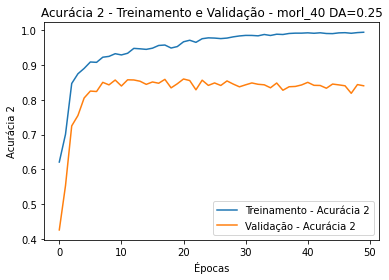

In [21]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - morl_40 DA=0.25')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da025'+'.pdf', format='pdf')
plt.show()

In [22]:
np.save('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da025',acc)
np.save('/content/drive/MyDrive/Resultados/morl_40_da/val_acc2_'+'da025',val_acc)

In [23]:
model.save('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da025')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da025')

### Training Results

In [24]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

138/138 [==============================] - 5s 35ms/step
(8827, 140)
(8827,)
(8827,)


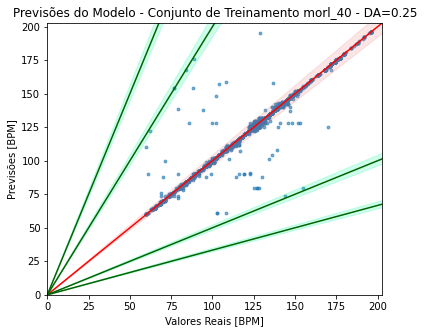

In [25]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento morl_40 - DA=0.25', '/content/drive/MyDrive/Resultados/morl_40_da/prev_train_'+'da025'+'.pdf')

In [26]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_morl_40_da025'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

           Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_morl_40_da025    0.919678    0.992976     0.993769


### Validation Results

In [27]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 36ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


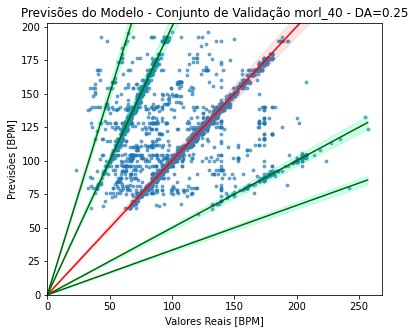

In [28]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação morl_40 - DA=0.25', '/content/drive/MyDrive/Resultados/morl_40_da/prev_validation_'+'da025'+'.pdf')

In [29]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_morl_40_da025'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

                Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_morl_40_da025    0.919678    0.992976     0.993769
1  validation_morl_40_da025    0.272377    0.608137     0.840043


In [30]:
resultados.to_excel("/content/drive/MyDrive/Resultados/morl_40_da/Resultados_morl_40_da025.xlsx", index=False)  

In [31]:
from google.colab import runtime
runtime.unassign()

# DA=0.5

In [5]:
#DA = 0.5

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/aval_morl_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/training_morl_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_morl_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(0.5, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8827, 40, 256, 1)
(4670, 40, 256, 1)
(8827,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.25342698538574826
Train - Acurácia 2:  0.6469921830746573
73/73 [==============================] - 3s 45ms/step
Validation - Acurácia 0:  0.09357601713062098
validation - Acurácia 2:  0.4552462526766595
138/138 [==============================] - 35s 160ms/step - loss: 4.0248 - accuracy: 0.1720
Epoch 2/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.3817831652883199
Train - Acurácia 2:  0.7866772402854877
73/73 [==============================] - 2s 34ms/step
Validation - Acurácia 0:  0.15331905781584582
validation - Acurácia 2:  0.6246252676659529
138/138 [==============================] - 19s 139ms/step - loss: 2.9504 - accuracy: 0.3046
Epoch 3/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.40353460972017674
Train - Acurácia 2:  0.8386767871303954
73/73 [==============================] - 2s 34ms/step
Validation - Acurácia 0:  0.1

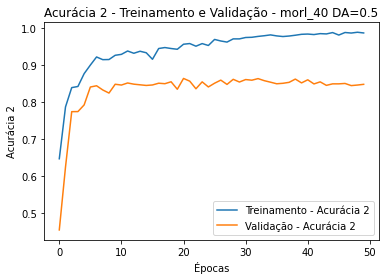

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - morl_40 DA=0.5')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da05'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da05',acc)
np.save('/content/drive/MyDrive/Resultados/morl_40_da/val_acc2_'+'da05',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da05')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da05')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

138/138 [==============================] - 5s 35ms/step
(8827, 140)
(8827,)
(8827,)


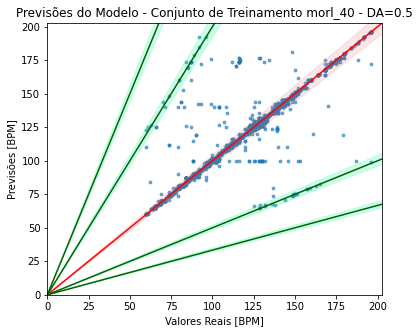

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento morl_40 - DA=0.5', '/content/drive/MyDrive/Resultados/morl_40_da/prev_train_'+'da05'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_morl_40_da05'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

          Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_morl_40_da05    0.849666    0.981534     0.985952


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


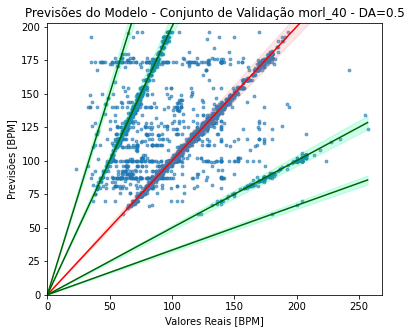

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação morl_40 - DA=0.5', '/content/drive/MyDrive/Resultados/morl_40_da/prev_validation_'+'da05'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_morl_40_da05'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

               Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_morl_40_da05    0.849666    0.981534     0.985952
1  validation_morl_40_da05    0.273019    0.616488     0.847537


In [28]:
resultados.to_excel("/content/drive/MyDrive/Resultados/morl_40_da/Resultados_morl_40_da05.xlsx", index=False)  

In [29]:
from google.colab import runtime
runtime.unassign()

# DA=0.75

In [5]:
#DA = 0.75

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/aval_morl_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/training_morl_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_morl_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(0.75, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8827, 40, 256, 1)
(4670, 40, 256, 1)
(8827,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.16449529851591707
Train - Acurácia 2:  0.5107057890563045
73/73 [==============================] - 3s 46ms/step
Validation - Acurácia 0:  0.06531049250535331
validation - Acurácia 2:  0.341541755888651
138/138 [==============================] - 36s 161ms/step - loss: 4.4618 - accuracy: 0.0965
Epoch 2/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.29545712019938825
Train - Acurácia 2:  0.7318454741135153
73/73 [==============================] - 3s 34ms/step
Validation - Acurácia 0:  0.1404710920770878
validation - Acurácia 2:  0.608779443254818
138/138 [==============================] - 19s 139ms/step - loss: 3.2358 - accuracy: 0.2521
Epoch 3/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.3857482723462105
Train - Acurácia 2:  0.7797666251274499
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.1830

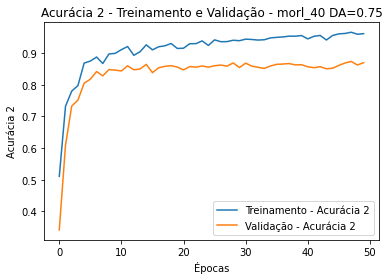

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - morl_40 DA=0.75')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da075'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da075',acc)
np.save('/content/drive/MyDrive/Resultados/morl_40_da/val_acc2_'+'da075',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da075')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da075')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

138/138 [==============================] - 5s 35ms/step
(8827, 140)
(8827,)
(8827,)


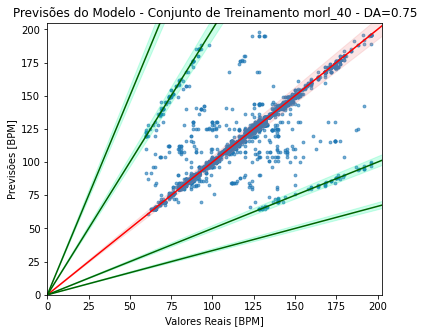

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento morl_40 - DA=0.75', '/content/drive/MyDrive/Resultados/morl_40_da/prev_train_'+'da075'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_morl_40_da075'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

           Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_morl_40_da075    0.665685    0.944942     0.961255


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


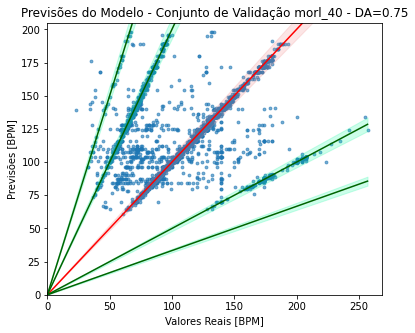

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação morl_40 - DA=0.75', '/content/drive/MyDrive/Resultados/morl_40_da/prev_validation_'+'da075'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_morl_40_da075'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

                Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_morl_40_da075    0.665685    0.944942     0.961255
1  validation_morl_40_da075    0.280300    0.633191     0.869593


In [28]:
resultados.to_excel("/content/drive/MyDrive/Resultados/morl_40_da/Resultados_morl_40_da075.xlsx", index=False)  

In [29]:
from google.colab import runtime
runtime.unassign()

# DA=1.0

In [5]:
#DA = 1.0

import zipfile

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/aval_morl_40.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Database/aval_morl_40/training_morl_40_review.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


### Tensors Definitions

In [6]:
TRAIN_DATASET = os.path.join("/content", "training_morl_40_review")
VAL_DATASET = os.path.join("/content", "COMBINADOS")
#TEST_DATASET = os.path.join("/content", "teste1")
METRONOMOS_DATASET = os.path.join("/content/drive/MyDrive/Database", "metronomos_review")
METRONOMOS_DATASET_VAL = os.path.join("/content/drive/MyDrive/Database", "metronomos")

classes = os.listdir(METRONOMOS_DATASET) #classes de 23 a 257
classes = sorted(classes)

classes_val = os.listdir(METRONOMOS_DATASET_VAL) 
classes_val = sorted(classes_val)

def make_dataset_aug(path, batch_size, classes_n):
   
    def parse_image_augmented(filename,label):
        primeiro_rand_value = tf.random.uniform((),minval=0.01, maxval=0.99)
        DA = tf.constant(1.0, dtype=tf.float32)   #### IMPORTANTE. ALTERAR O VALOR DA CONSTANTE DE DATA AUGMENTATION
        tf_cond0 = tf.math.less_equal(primeiro_rand_value,DA)
        def func_a():            
            a = tf.random.uniform((),minval=0.08, maxval=0.12)
            b = tf.constant(100, dtype=tf.float32)
            c = tf.multiply(a,b)
            c = tf.math.round(c)
            d = tf.constant(10, dtype=tf.float32)
            rand_value = tf.math.divide(c,d)                    
            label_real = tf.strings.split(filename, os.sep)[-2] 
            label_real = tf.strings.to_number(label_real, tf.float32)
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            tf_60 = tf.constant(60)
            tf_199 = tf.constant(199)
            tf_cond1 = tf.math.less_equal(label_aug,tf_60)
            tf_cond2 = tf.math.greater_equal(label_aug,tf_199)
            tf_cond = tf.math.logical_or(tf_cond1, tf_cond2)            
            def f1(): return 1.0
            def f2(): return rand_value
            fator=tf.cond(tf_cond, f1, f2)
            rand_value = fator            
            label_aug = tf.multiply(label_real,rand_value)      
            label_aug = tf.math.round(label_aug)
            label_aug = tf.cast(label_aug, tf.int32)            
            label_aug = tf.as_string(label_aug)
            label_aug = tf.experimental.numpy.where((np.array(classes)==label_aug))
            label_aug = label_aug[0][0]
            label_aug = tf.cast(label_aug, dtype=tf.int32)                      
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            #width = int(np.around(256*fator,0)) 
            width=tf.multiply(tf.constant(256, dtype=tf.float32),fator)
            image_aug = tf.image.random_crop(image,size=(40, width,1))
            image_aug = tf.image.resize(image_aug, [40,256]) #height, width)
            image_aug = tf.image.per_image_standardization(image_aug)
            return image_aug, label_aug
        def func_b():
            image = tf.io.read_file(filename)
            image = tf.image.decode_jpeg(image, channels=3)
            image = tf.image.rgb_to_grayscale(image)
            image = tf.image.per_image_standardization(image)
            image_aug = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
            label_aug = label
            return image_aug, label_aug
        image_aug, label_aug = tf.cond(tf_cond0, func_a, func_b)
        return image_aug, label_aug
 
    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

     #Pegar todas as classes possíveis
    classes_n=classes_n
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)    
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices((filenames,labels))
    ds=filenames_ds.map(lambda x,y: parse_image_augmented(x,y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = configure_for_performance(ds)

    return ds

In [7]:
print(classes)
print(classes_val)

['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']
['100', '101', '102', '103', '104', '105', '106', '107', '1

In [8]:
trainAugDS = make_dataset_aug(TRAIN_DATASET, config.BS, classes)
print(trainAugDS)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [9]:
def make_dataset_simple(path, batch_size, classes_n):
    def parse_image(filename):
        image = tf.io.read_file(filename)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.per_image_standardization(image)
        image = tf.image.crop_to_bounding_box(image, 0, 108, 40, 256)
        return image

    def configure_for_performance(ds):
        ds = ds.shuffle(buffer_size=1000)
        ds = ds.batch(batch_size)
        ds = ds.repeat()
        ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        return ds

    classes_n = classes_n #classes de 23 a 257
    classes_n = sorted(classes_n)
    filenames = glob(path + '/*/*')
    random.shuffle(filenames)
    labels = [classes_n.index(name.split('/')[-2]) for name in filenames]   #\Necessário abrir este laço no caso de regressão
    
    filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
    images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    ds = tf.data.Dataset.zip((images_ds, labels_ds))
    ds = configure_for_performance(ds)

    return ds,classes_n,images_ds,labels_ds

In [10]:
trainDS, classes_t, images_train, labels_train = make_dataset_simple(TRAIN_DATASET, config.BS, classes) #labels com valores 0 a 234
validationDS, classes_v, images_validation, labels_validation = make_dataset_simple(VAL_DATASET, config.BS, classes_val) #labels com valores 0 a 234
#testDS, classes_te, images_test, labels_test = make_dataset_simple(TEST_DATASET, config.BS)

In [11]:
list_images_train = list(images_train.as_numpy_iterator())

In [12]:
list_images_validation = list(images_validation.as_numpy_iterator())

In [ ]:
#list_images_test = list(images_test.as_numpy_iterator())

In [13]:
list_labels_train = list(labels_train.as_numpy_iterator())
labels_train_true = []
for i in list_labels_train:
       labels_train_true.append(classes[i])
labels_train_true = np.array(labels_train_true, int) #labels de 23 a 257


list_labels_validation = list(labels_validation.as_numpy_iterator())
labels_validation_true = []
for i in list_labels_validation:
       labels_validation_true.append(classes_val[i])
labels_validation_true = np.array(labels_validation_true, int)  #labels de 23 a 257

#list_labels_test= list(labels_test.as_numpy_iterator())
#labels_test_true = []
#for i in list_labels_test:
#       labels_test_true.append(classes[i])
#labels_test_true = np.array(labels_test_true, int)  #labels de 23 a 257

In [14]:
images_train_ds = np.array(list_images_train)
print(images_train_ds.shape)
images_validation_ds = np.array(list_images_validation)
print(images_validation_ds.shape)
#images_test_ds = np.array(list_images_test)
print(labels_train_true.shape)
print(labels_validation_true.shape)
#print(labels_test_true.shape)
print(trainAugDS)
print(trainDS)
print(validationDS)
#print(testDS)

(8827, 40, 256, 1)
(4670, 40, 256, 1)
(8827,)
(4670,)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 40, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
#print(images_train_ds[1])

In [15]:
num_images_predict = len(glob(TRAIN_DATASET + '/*/*'))
num_images_val = len(glob(VAL_DATASET + '/*/*'))
steps_per_epoch_predict =math.ceil(num_images_predict/config.BS)
validation_steps = math.ceil(num_images_val/config.BS)

#Criando o multilabel binarizer:

mlb = MultiLabelBinarizer()
dicionario = mlb.fit_transform([classes])

In [16]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(loss ='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [17]:
accuracy0_train=[]
accuracy0_validation=[]
accuracy2_train=[]
accuracy2_validation=[]
class Accuracy2(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
        arg_max_train = np.argmax(train_predictions, axis=1)
        shape_train = train_predictions.shape
        for i in range(0,shape_train[0]):
            for j in range(0,shape_train[1]):
                if (j==arg_max_train[i]):
                    train_predictions[i][j]=1
                else:
                    train_predictions[i][j]=0    
        train_predictions = mlb.inverse_transform(train_predictions)
        train_predictions = np.array(train_predictions)
        train_predictions = train_predictions.astype(int)
        train_predictions = np.reshape(train_predictions, (train_predictions.size,))
        print("Train - Acurácia 0: ",acuracia0(labels_train_true, train_predictions))
        accuracy0_train.append(acuracia0(labels_train_true, train_predictions))        
        print("Train - Acurácia 2: ",acuracia2(labels_train_true, train_predictions))
        accuracy2_train.append(acuracia2(labels_train_true, train_predictions))            
        
        validation_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
        #print(train_predictions.shape)
        arg_max_validation = np.argmax(validation_predictions, axis=1)
        #print(arg_max)
        #print(arg_max)
        shape_validation = validation_predictions.shape
        #print(shape[0])
        for i in range(0,shape_validation[0]):
            for j in range(0,shape_validation[1]):
                if (j==arg_max_validation[i]):
                    validation_predictions[i][j]=1
                else:
                    validation_predictions[i][j]=0  
        validation_predictions= mlb.inverse_transform(validation_predictions)
        validation_predictions= np.array(validation_predictions)
        validation_predictions = validation_predictions.astype(int)
        validation_predictions = np.reshape(validation_predictions, (validation_predictions.size,))
        print("Validation - Acurácia 0: ",acuracia0(labels_validation_true, validation_predictions))
        accuracy0_validation.append(acuracia0(labels_validation_true, validation_predictions))        
        print("validation - Acurácia 2: ",acuracia2(labels_validation_true, validation_predictions))
        accuracy2_validation.append(acuracia2(labels_validation_true, validation_predictions))   
        

### Model.fit

In [18]:
%%time
history = model.fit(trainAugDS, epochs=50, batch_size=config.BS, steps_per_epoch=steps_per_epoch_predict ,verbose=1, callbacks=[Accuracy2()])

Epoch 1/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.1668743627506514
Train - Acurácia 2:  0.5060609493599184
73/73 [==============================] - 3s 46ms/step
Validation - Acurácia 0:  0.0576017130620985
validation - Acurácia 2:  0.34817987152034263
138/138 [==============================] - 36s 161ms/step - loss: 4.4679 - accuracy: 0.0839
Epoch 2/50
138/138 [==============================] - 5s 35ms/step
Train - Acurácia 0:  0.2564857822589781
Train - Acurácia 2:  0.6850572108304067
73/73 [==============================] - 3s 34ms/step
Validation - Acurácia 0:  0.13147751605995717
validation - Acurácia 2:  0.5957173447537473
138/138 [==============================] - 19s 140ms/step - loss: 3.2860 - accuracy: 0.2371
Epoch 3/50
138/138 [==============================] - 5s 34ms/step
Train - Acurácia 0:  0.3225331369661267
Train - Acurácia 2:  0.8043502888863714
73/73 [==============================] - 3s 35ms/step
Validation - Acurácia 0:  0.179

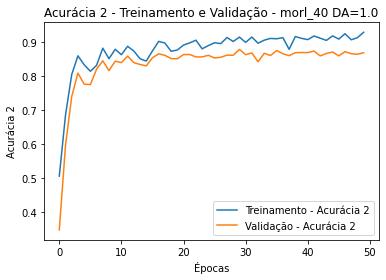

In [19]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = accuracy2_train
val_acc  = accuracy2_validation


epochs   = range(len(acc)) # Get number of epochs
epochs2 = range(len(val_acc))

plt.plot  ( epochs,     acc, label='Treinamento - Acurácia 2')
plt.plot  ( epochs2, val_acc, label='Validação - Acurácia 2' )
plt.title ('Acurácia 2 - Treinamento e Validação - morl_40 DA=1.0')
plt.xlabel('Épocas')
plt.ylabel('Acurácia 2')
plt.legend()
plt.savefig('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da1'+'.pdf', format='pdf')
plt.show()

In [20]:
np.save('/content/drive/MyDrive/Resultados/morl_40_da/acc2_'+'da1',acc)
np.save('/content/drive/MyDrive/Resultados/morl_40_da/val_acc2_'+'da1',val_acc)

In [21]:
model.save('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da1')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Resultados/morl_40_da/morl_40_da1')

### Training Results

In [22]:
train_predictions = model.predict(images_train_ds, batch_size=config.BS, steps=steps_per_epoch_predict, verbose=1)
print(train_predictions.shape)
arg_max = np.argmax(train_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = train_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            train_predictions[i][j]=1
        else:
            train_predictions[i][j]=0 
mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

train_pred_new = mlb.inverse_transform(train_predictions)
train_pred_new = np.array(train_pred_new, int)
train_pred_new = np.reshape(train_pred_new, (train_pred_new.size,))

print(train_pred_new.shape)
print(labels_train_true.shape)

138/138 [==============================] - 5s 35ms/step
(8827, 140)
(8827,)
(8827,)


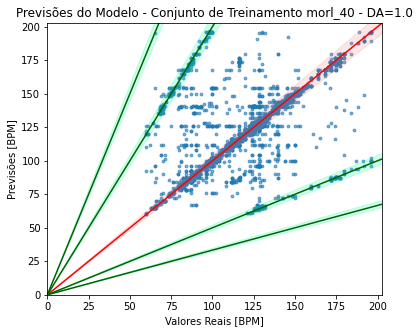

In [23]:
utilities.MakeGraphicPredictions(labels_train_true, train_pred_new, 'Previsões do Modelo - Conjunto de Treinamento morl_40 - DA=1.0', '/content/drive/MyDrive/Resultados/morl_40_da/prev_train_'+'da1'+'.pdf')

In [24]:
acc0 = utilities.acuracia0(labels_train_true, train_pred_new)
acc1 = utilities.acuracia1(labels_train_true, train_pred_new)
acc2 = utilities.acuracia2(labels_train_true, train_pred_new)

experimento = 'train_morl_40_da1'
resultados = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

print(resultados)

         Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0  train_morl_40_da1    0.534496    0.888411     0.928515


### Validation Results

In [25]:
num_images_val = len(glob(VAL_DATASET + '/*/*'))
validation_steps = math.ceil(num_images_val/config.BS)

val_predictions = model.predict(images_validation_ds, batch_size=config.BS, steps=validation_steps, verbose=1)
print(val_predictions.shape)
arg_max = np.argmax(val_predictions, axis=1)
#print(arg_max)
#print(arg_max)
shape = val_predictions.shape
#print(shape[0])
for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if (j==arg_max[i]):
            val_predictions[i][j]=1
        else:
            val_predictions[i][j]=0  

print(val_predictions.shape)

mlb = MultiLabelBinarizer()

dicionario = mlb.fit_transform([classes])
#print(mlb.classes_)

val_pred_new = mlb.inverse_transform(val_predictions)
val_pred_new = np.array(val_pred_new, int)
val_pred_new = np.reshape(val_pred_new, (val_pred_new.size,))

print(val_pred_new.shape)
print(labels_validation_true.shape)

73/73 [==============================] - 3s 35ms/step
(4670, 140)
(4670, 140)
(4670,)
(4670,)


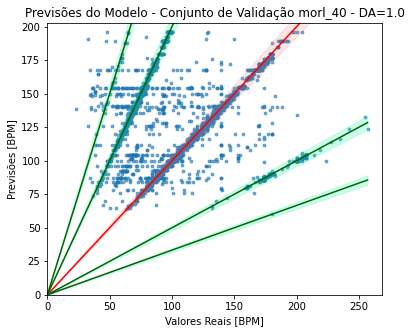

In [26]:
utilities.MakeGraphicPredictions(labels_validation_true, val_pred_new, 'Previsões do Modelo - Conjunto de Validação morl_40 - DA=1.0', '/content/drive/MyDrive/Resultados/morl_40_da/prev_validation_'+'da1'+'.pdf')

In [27]:
acc0 = utilities.acuracia0(labels_validation_true, val_pred_new)
acc1 = utilities.acuracia1(labels_validation_true, val_pred_new)
acc2 = utilities.acuracia2(labels_validation_true, val_pred_new)

experimento = 'validation_morl_40_da1'
newline = pd.DataFrame([[experimento, acc0, acc1, acc2]], columns=['Experimento','Acurácia 0', 'Acurácia 1', 'Acuarária 2'])

resultados = resultados.append(newline, ignore_index=True)

print(resultados)

              Experimento  Acurácia 0  Acurácia 1  Acuarária 2
0       train_morl_40_da1    0.534496    0.888411     0.928515
1  validation_morl_40_da1    0.263812    0.609636     0.868308


In [28]:
resultados.to_excel("/content/drive/MyDrive/Resultados/morl_40_da/Resultados_morl_40_da1.xlsx", index=False)  

In [29]:
from google.colab import runtime
runtime.unassign()